<!-- ![image.png](attachment:image.png) -->

In [1]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.optimize as opt
from itertools import product
from uncertainties import ufloat


In [2]:
def LS_fit_ymxb(data_x,data_y,SDM_data):
    ystd = 0 #calculation of each of the sums
    xstd = 0
    xystd = 0
    x2std = 0
    std2 = 0
    for x,y,i_std in zip(data_x,data_y,SDM_data):
        ystd += y/i_std**2
        xstd += x/i_std**2
        xystd += x*y/i_std**2
        x2std += x**2/i_std**2
        std2 += 1/i_std**2
  #now all the sums have formed just have to find a,b,delt
    matrix_a = np.array([[ystd, xstd],[xystd, x2std]])
    matrix_b = np.array([[std2, ystd],[xstd, xystd]])
    matrix_delta = np.array([[std2, xstd],[xstd, x2std]])
    delta = np.linalg.det(matrix_delta)
    a = (1/delta) * np.linalg.det(matrix_a)
    b = (1/delta) * np.linalg.det(matrix_b)
    unc_a = ((1/delta) * x2std)**.5
    unc_b = ((1/delta) * std2)**.5
    mxslope = xystd/x2std
    mxslope_unc = (x2std)**-.5
    #print(f'for y=bx+a, b: {b} +- {unc_b}, a: {a} +- {unc_a} and for y=bx, b: {mxslope} +- {mxslope_unc}')
    return [b,unc_b,a,unc_a,mxslope,mxslope_unc]

def chi_squared_of_y_ax_plus_b(slope,y_intercept,slope2,data_x,data_y,SDM,DF1,DF2): 
    sum_chi = 0
    sum_chi_for_ybx = 0
    for x,y,i_SDM in zip(data_x,data_y,SDM):
        sum_chi += ((y - y_intercept - slope*x)/i_SDM)**2
        sum_chi_for_ybx += ((y - slope2*x)/i_SDM)**2
    return [sum_chi, sum_chi/DF1, sum_chi_for_ybx, sum_chi_for_ybx/DF2]

def sample_standard_deviation(sample):
    mean_sample = np.mean(sample)
    N = len(sample)
    sum_sample = 0
    for i in sample:
        sum_sample += (i - mean_sample)**2
        sample_std = ((sum_sample)/(N-1))**0.5
    return sample_std

def calculate_chi2(z,B_s,theoretical_B_s,error_bars,parameters_fit):
    result = 0
    n_parameters = len(z) - parameters_fit
    for i in range(len(z)):
        exp_B = B_s[i]
        sim_B = theoretical_B_s[i]
        error_bar = error_bars[i]

        contribution = np.square((exp_B-sim_B)/error_bar)
        result += contribution
    return result/n_parameters


In [3]:
#Experimental Parameters

df = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx')
dfBL2 = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name='BL2')

Mean_B = dfBL2['Means'].to_numpy()[1:-2]#[:-1] #mT
SDM_B0 = dfBL2['SDM\'s'].to_numpy()[1:-2]*8.3#[:-1]
SDM_B = np.array([np.mean(SDM_B0)]*len(SDM_B0))
exp_Ls = np.arange(5,40+5,5)/100 #np.arange(0,45+5,5)/100 #meters
print(len(exp_Ls))
#print(df)
long = np.array(df['B long (cm)'].to_list()) #cm
lip = 4.8 #mm

Length = np.mean(long[~np.isnan(long)])/100 - 2*lip/1000


8


In [4]:
def solenoid(z,L,I,R,n):
    u = 1.25663706 * 10**(-6) #m*kgs/(s^2 * amps^2)
    #n=7.27*100 #number of turns/meter
    return u*n*I/2 * (z/np.sqrt(R**2 + z**2) - (z-L)/np.sqrt(R**2 + (z-L)**2))

def net_B(z,L,I,R,n,t):
    #t = 1.4/1000 #rough idea wire is about a mm, each wire is sperated by t thickness, diameter of wire
    wraps = 16
    B_value = 0
    for i in range(wraps):
        B_value += solenoid(z,L,I,R+t*(i+1),n)
    return B_value

t = 1.4/1000
n = 7.27*100 #number of turns/meter
z = np.linspace(0,Length,1000)
I = 2.001 #amps
R = (7.642/200+1.4/2000) #meters, outercore/2 +thickness of wire/2 so its radius

print(R)
print(n)
print(Length)
#calculated from prev run
R = 0.040753105263157896
n = 738.478947368421
Length = 0.4688376315789474
#adjust R, L, t, n
split = 0.1
n_points = 10 #change to speed up or slow down code
Rs = np.linspace(R*(1-split),R*(1+split),n_points)
ns = np.linspace(n*(1-split),n*(1+split),n_points)
Ls = np.linspace(Length*(1-split),Length*(1+split),n_points)

combos = product(Rs,ns,Ls)
chi = np.inf
for R,n,L in combos:
    b_temp = []
    for z in exp_Ls:
        b_temp.append(net_B(z,L,I,R,n,t)*1000)
    chi_temp = calculate_chi2(exp_Ls,Mean_B,b_temp,SDM_B,3)
    if chi_temp<chi:
        chi = chi_temp
        params = [R,n,L]

#print(f'Reduced {chi}')
#print(f'R, n, L{params}')

#get histereses using our best point
#believe hall probe and look up uncertainty for sytematic error
#fitting to data to get best values of B to use in our faraday calc
#less than a percent for off axis measurement (could try to fix), prob not good enough do

0.03891
727.0
0.46155


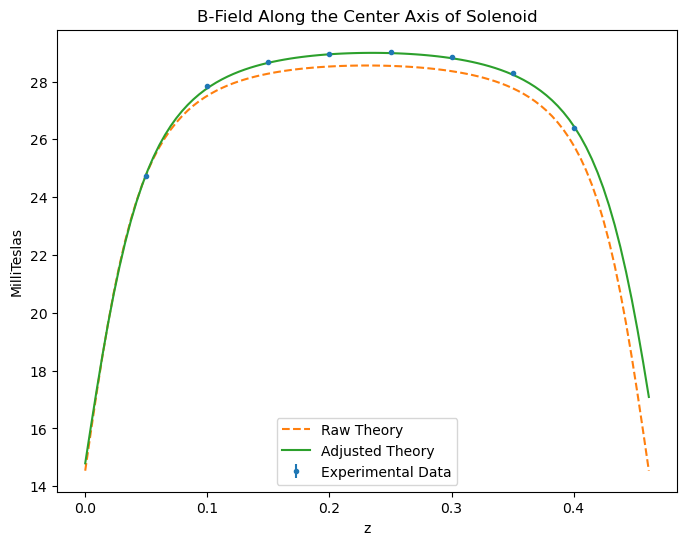

[0.05704277 0.05704277 0.05704277 0.05704277 0.05704277 0.05704277
 0.05704277 0.05704277]


In [5]:
fix_params = [0.04315649352226721, 740.3724831309041, 0.4700397793522268]

z = np.linspace(0,0.46155,100)
B_s = net_B(z,fix_params[2],I,fix_params[0],fix_params[1],t)*1000
plt.figure(figsize=(8,6))
plt.errorbar(exp_Ls,Mean_B,yerr=SDM_B,fmt='.',label='Experimental Data')

plt.plot(z,net_B(z,np.mean(long[~np.isnan(long)])/100 - 2*lip/1000,I,(7.642/200+1.4/2000),7.27*100,1.4/1000)*1000,'--',label='Raw Theory')

plt.plot(z, B_s, label='Adjusted Theory')
plt.title('B-Field Along the Center Axis of Solenoid')
plt.ylabel('MilliTeslas')
plt.xlabel('z')
plt.legend(loc='best')
plt.show()
print(SDM_B)

Reduced Chi-Squared: 0.12553688698315146
Verdet Constant: (981123.1925613162, 9294.882293027604)
Verdet Constant: (17123830.077873304, 162226.29959865205)


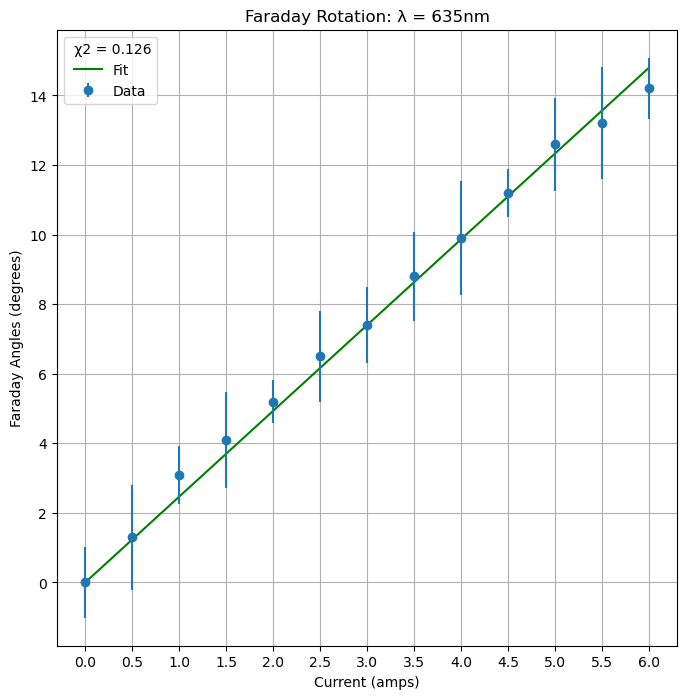

In [14]:
def B_theory(z,I):
    t = 1.4/1000 #rough idea wire is about a mm, each wire is sperated by t thickness, diameter of wire
    R = 0.043156 #found from the combos and parameter adjusting
    n = 740.3725
    L = 0.470039
    
    wraps = 16
    B_value = 0
    for i in range(wraps):
        B_value += solenoid(z,L,I,R+t*(i+1),n)
    return B_value

def B_avg(I,sz1,sz2):
    sL = sz2-sz1
    z_vals = np.random.uniform(sz1,sz2,5000)
    return np.mean(B_theory(z_vals,I)) #works cuz b-a/b-a in monte carlo integration

def wMean_wStd(mean_list, std_list): #weighted mean based off of the standard deviations
    sum_top = 0
    sum_bottom = 0
    for i,j in zip(mean_list,std_list):
        sum_top += i/j**2
        sum_bottom += 1/j**2
    weighted_mean = sum_top/sum_bottom
    weighted_std = (1/sum_bottom)**0.5
    return  (weighted_mean, weighted_std)

def calc_z_range(left,right,sampleL,mat): #in inches
    total_solenoid_length = np.array(df['B long (cm)'].to_list()) #cm
    lip = 4.8/1000 #mm 
    solenoid_L = np.mean(total_solenoid_length[~np.isnan(total_solenoid_length)])/100 #- 2*lip/1000
    if mat == 'yag':
        start1 = left/39.37 - lip#meters
        start2 = right/39.37 - lip
        gap = (sampleL + start1 + start2 - solenoid_L)/2 #assumes symmetrical 
        z1 = start1 - gap
        z2 = start2 + gap
        return z1, z2
    elif mat == 'sugar':
        start1 = left/39.37
        z1 = start1
        z2 = start1 + sampleL
        return z1, z2

def faraday(sheet,maxI,sampleL,mat):
    dfFR = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name=sheet).T
    dfFRT = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name=sheet)
    left = dfFRT.columns[1]
    right = list(dfFR[0])[1]

    #calculate fit
    I = np.arange(0, maxI+0.5, 0.5)
    FR_angles = []
    for i in range(len(I)):
        FR_angles.append(dfFR[4*i+5].to_numpy()[1:11])
    
    FR_vals =  np.mean(FR_angles,axis=1)-np.mean(FR_angles[0])
    FR_sdm = np.array([sample_standard_deviation(i)/np.sqrt(len(i)) for i in FR_angles])
    fits = LS_fit_ymxb(I,FR_vals,FR_sdm) #does same thing as scypy optimize!!!!! but with uncertainties
    m = fits[-2]
    munc = fits[-1]
    #chi_squared_of_y_ax_plus_b(slope,y_intercept,slope2,data_x,data_y,SDM,DF1,DF2)
    
    #FR_sdm = [0.4]*len(FR_sdm) #for rotation1
    FR_sdm = [0.4]*len(FR_sdm) #for rotation2
    chi=chi_squared_of_y_ax_plus_b(1,1,m,I,FR_vals,FR_sdm,1,len(I)-1)[-1]
    print(f'Reduced Chi-Squared: {chi}')
    #calculate verdet constant
    verdets = []
    zLeft, zRight = calc_z_range(left,right,sampleL,mat)
    for i in range(1,len(I)):
        Bavg = B_avg(I[i],zLeft,zRight)*1000 #get into mT
        B_er = ufloat(np.mean(Bavg),np.sqrt(np.std(Bavg)**2 + 0.05704**2))
        m_er = ufloat(m,munc)
        gamma  = I[i]/B_er #slightly different Bavg cuz of montecarlo randomness
        verdets.append(m_er/sampleL * gamma)

    vals_verdet = [i.n for i in verdets]
    sdms_verdet = [i.s for i in verdets]

    final_verdet = wMean_wStd(vals_verdet,sdms_verdet)
    print(f'Verdet Constant: {final_verdet}')
    print(f'Verdet Constant: {(final_verdet[0]*np.pi/(180*0.001),final_verdet[1]*np.pi/(180*0.001))}')
    
    #plotting
    plt.title('Faraday Rotation: λ = 450nm')
    plt.plot(I,I*m,color='green',label='Fit')
    plt.errorbar(I, FR_vals,yerr=FR_sdm, fmt='o',label='Data')
    plt.ylabel('Faraday Angles (degrees)')
    plt.xlabel('Current (amps)')
    plt.xticks(I)
    plt.grid()
    plt.legend(title = f' χ2 = {np.round(chi,3)}')
    return #m, munc #slope and slope unc

def chiral_faraday(sheet,maxI,point_drop,sampleL,mat):
    dfFR = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name=sheet).T
    dfFRT = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name=sheet)
    left = dfFRT.columns[1]
    right = list(dfFR[0])[1]
    
    I = np.arange(0, maxI+0.5, 0.5)
    FR_angles = []
    for i in range(len(I)+1): #+1 for last chiral line to get intercept
        FR_angles.append(dfFR[4*i+5].to_numpy()[1:11])

    noMedium = FR_angles[-1]
    FR = FR_angles[0:-1]
    if point_drop != 0:
        FR_vals =  np.mean(FR,axis=1)[:-point_drop]-np.mean(noMedium) #doesn't show chirality??? should fix I guess
        FR_sdm = np.array([sample_standard_deviation(i)/np.sqrt(len(i)) for i in FR])[:-point_drop]
        I_pdrop = I[:-point_drop]
        fits = LS_fit_ymxb(I_pdrop,FR_vals,FR_sdm) #does same thing as scypy optimize!!!!!!!!! but with uncertainties
        m = fits[0]
        munc = fits[1]
        intercept = fits[2]

        chi=chi_squared_of_y_ax_plus_b(m,intercept,1,I_pdrop,FR_vals,FR_sdm,len(I_pdrop)-2,1)[1]
        print(f'Reduced Chi-Squared: {chi}')
        
        #calculate verdet constant
        verdets = []
        zLeft, zRight = calc_z_range(left,right,sampleL,mat)
        for i in range(1,len(I_pdrop)):
            Bavg = B_avg(I_pdrop[i],zLeft,zRight)*1000 #get into mT
            B_er = ufloat(np.mean(Bavg),np.sqrt(np.std(Bavg)**2 + 0.05704**2))
            m_er = ufloat(m,munc)
            gamma  = I_pdrop[i]/B_er #slightly different Bavg cuz of montecarlo randomness
            verdets.append(m_er/sampleL * gamma)

        vals_verdet = [i.n for i in verdets]
        sdms_verdet = [i.s for i in verdets]

        final_verdet = wMean_wStd(vals_verdet,sdms_verdet)
        print(f'Verdet Constant: {final_verdet}')
        print(f'Verdet Constant: {(final_verdet[0]*np.pi/(180*0.001),final_verdet[1]*np.pi/(180*0.001))}')

        
        #plot
        plt.title('Faraday Rotation: λ = 535nm')
        plt.plot(I_pdrop,I_pdrop*fits[0]+fits[2],color='green',label = 'Fit')
        plt.errorbar(I_pdrop, FR_vals,yerr=FR_sdm, fmt='o',label = 'Data')
        plt.ylabel('Faraday Angles (degrees)')
        plt.xlabel('Current (amps)')
        plt.xticks(I_pdrop)
        plt.grid()
        plt.legend(title = f' χ2 = {np.round(chi,3)}')
        return #fits[0], fits[1], chi
    else:
        FR_vals =  np.mean(FR,axis=1)-np.mean(noMedium) #doesn't show chirality??? should fix I guess
        FR_sdm = np.array([sample_standard_deviation(i)/np.sqrt(len(i)) for i in FR])
        I_pdrop = np.arange(0, maxI+0.5, 0.5)
        fits = LS_fit_ymxb(I_pdrop,FR_vals,FR_sdm) #does same thing as scypy optimize!!!!!!!!! but with uncertainties
        m = fits[0]
        munc = fits[1]
        intercept = fits[2]
        chi=chi_squared_of_y_ax_plus_b(m,intercept,1,I_pdrop,FR_vals,FR_sdm,len(I_pdrop)-2,1)[1]
        #calculate verdet constant
        verdets = []
        zLeft, zRight = calc_z_range(left,right,sampleL,mat)
        for i in range(1,len(I_pdrop)):
            Bavg = B_avg(I_pdrop[i],zLeft,zRight)*1000 #get into mT
            B_er = ufloat(np.mean(Bavg),np.sqrt(np.std(Bavg)**2 + 0.05704**2))
            
            m_er = ufloat(m,munc)
            gamma  = I_pdrop[i]/B_er #slightly different Bavg cuz of montecarlo randomness
            verdets.append(m_er/sampleL * gamma)

        vals_verdet = [i.n for i in verdets]
        sdms_verdet = [i.s for i in verdets]

        final_verdet = wMean_wStd(vals_verdet,sdms_verdet)
        print(f'Verdet Constant: {final_verdet}')
        print(f'Verdet Constant: {(final_verdet[0]*np.pi/(180*0.001),final_verdet[1]*np.pi/(180*0.001))}')

        plt.title('Faraday Rotation: λ = 535nm')
        plt.plot(I_pdrop,I_pdrop*fits[0]+fits[2],color='green',label='Fit')
        plt.errorbar(I_pdrop, FR_vals,yerr=FR_sdm, fmt='o',label='Data')
        plt.ylabel('Faraday Angles')
        plt.xlabel('Current (amps)')
        plt.grid()
        plt.legend(title = f' χ2 = {np.round(chi,3)}')
    return #fits[0], fits[1], chi


def fiber_faraday(sheet,maxI,loops):
    dfFR = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name=sheet).T
    dfFRT = pd.read_excel(r'C:\Users\Hayden Swanson\OneDrive\HaydSwanMeta\JupyterCode\Physics 422\FaradayData.xlsx',sheet_name=sheet)

    #calculate fit
    I = np.arange(0, maxI+0.5, 0.5)
    FR_angles = []
    for i in range(len(I)):
        FR_angles.append(dfFR[4*i+5].to_numpy()[1:11])
    
    FR_vals =  np.mean(FR_angles,axis=1)-np.mean(FR_angles[0])
    FR_sdm = np.array([sample_standard_deviation(i)/np.sqrt(len(i)) for i in FR_angles])
    fits = LS_fit_ymxb(I,FR_vals,FR_sdm) #does same thing as scypy optimize!!!!! but with uncertainties
    m = fits[-2]
    munc = fits[-1]
    #chi_squared_of_y_ax_plus_b(slope,y_intercept,slope2,data_x,data_y,SDM,DF1,DF2)
    
    #FR_sdm = [0.4]*len(FR_sdm)
    chi=chi_squared_of_y_ax_plus_b(1,1,m,I,FR_vals,FR_sdm,1,len(I)-1)[-1]
    print(f'Reduced Chi-Squared: {chi}')

    #calculate verdet constant
    verdets = []
    for i in range(1,len(I)):
        m_er = ufloat(m,munc)
        verdets.append(m_er/(1.2566*10**(-6)) * 1/(loops))

    vals_verdet = [i.n for i in verdets]
    sdms_verdet = [i.s for i in verdets]

    final_verdet = wMean_wStd(vals_verdet,sdms_verdet)
    print(f'Verdet Constant: {final_verdet}')
    print(f'Verdet Constant: {final_verdet[0]*np.pi/(180*0.001),final_verdet[1]*np.pi/(180*0.001)}')

    #plotting
    plt.figure(figsize=(8,8))
    plt.title('Faraday Rotation: λ = 635nm')
    plt.plot(I,I*m,color='green',label='Fit')
    plt.errorbar(I, FR_vals,yerr=FR_sdm, fmt='o',label='Data')
    plt.ylabel('Faraday Angles (degrees)')
    plt.xlabel('Current (amps)')
    plt.xticks(I)
    plt.grid()
    plt.legend(title = f' χ2 = {np.round(chi,3)}')
    return

yag_length =  115.5/1000 #m
sugar_length = 6.9375/39.37 #m

#faraday('Rotation1',5.5, yag_length, 'yag')
#faraday('Rotation2',6,yag_length, 'yag')
#chiral_faraday('Rotation3',6,3,sugar_length,'sugar')
#chiral_faraday('Rotation4',6,0,sugar_length,'sugar')

fiber_faraday('Rotation6',6,2)

In [ ]:
#optical rotatory power at love library
#